Generating Data...


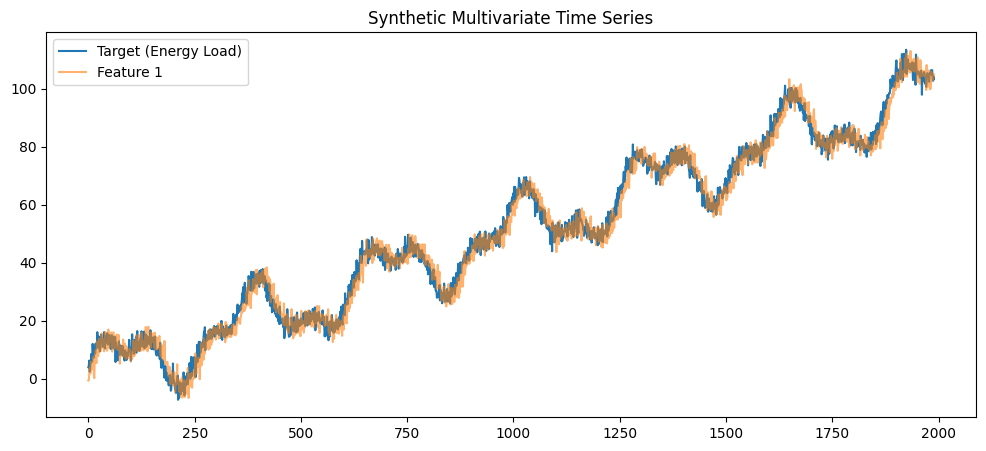

Full sequence shapes: (1930, 60, 3) (1930, 1)
Training Shape: (1544, 60, 3), Testing Shape: (386, 60, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 64)              │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM Model...
Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.0199 - mae: 0.0935 - val_loss: 0.0023 - val_mae: 0.0393 - learning_rate: 0.0010
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0041 - mae: 0.0492 - val_loss: 0.0042 - val_mae: 0.0580 - learning_rate: 0.0010
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0033 - mae: 0.0439 - val_loss: 0.0030 - val_mae: 0.0481 - learning_rate: 0.0010
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0031 - mae: 0.0422 - val_loss: 8.3888e-04 - val_mae: 0.0232 - learning_rate: 0.0010
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0029 - mae: 0.0414 - val_loss: 7.2363e-04 - val_mae: 0.0215 - learning_rate: 0.0010
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0026 - mae: 0.0389 - val_loss: 0.0021 - val_mae: 0.0408 - learning_rate: 0.0010
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0025 - mae: 0.0377 - val_loss: 5.7004e-04 - val_mae: 0.0194 -

  0%|          | 0/10 [00:00<?, ?it/s]

SHAP explainer used: KernelExplainer. Time taken: 141.1s
shap_values.shape: (10, 60, 3)


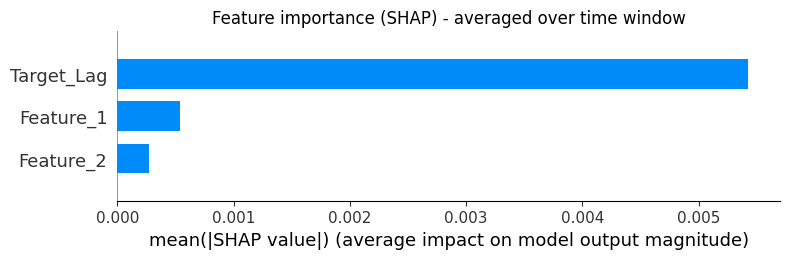

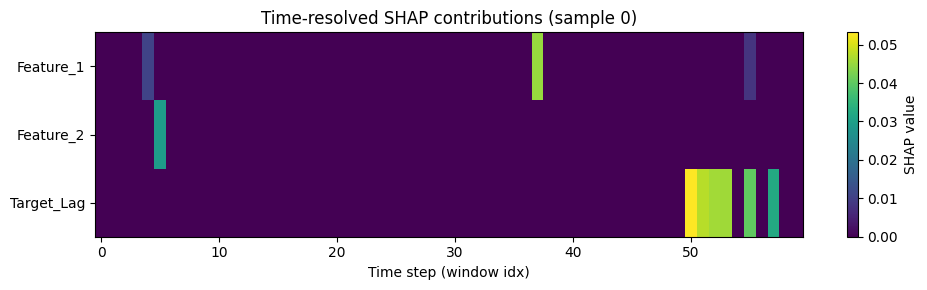


Training Statistical Baseline (ARIMA)...

=== Final Comparative Analysis ===
--- Deep Learning (LSTM) Metrics ---
RMSE: 2.3102
MAE:  1.8317
MAPE: 2.00%
--- Baseline (ARIMA) Metrics ---
RMSE: 18.0023
MAE:  15.1042
MAPE: 15.47%


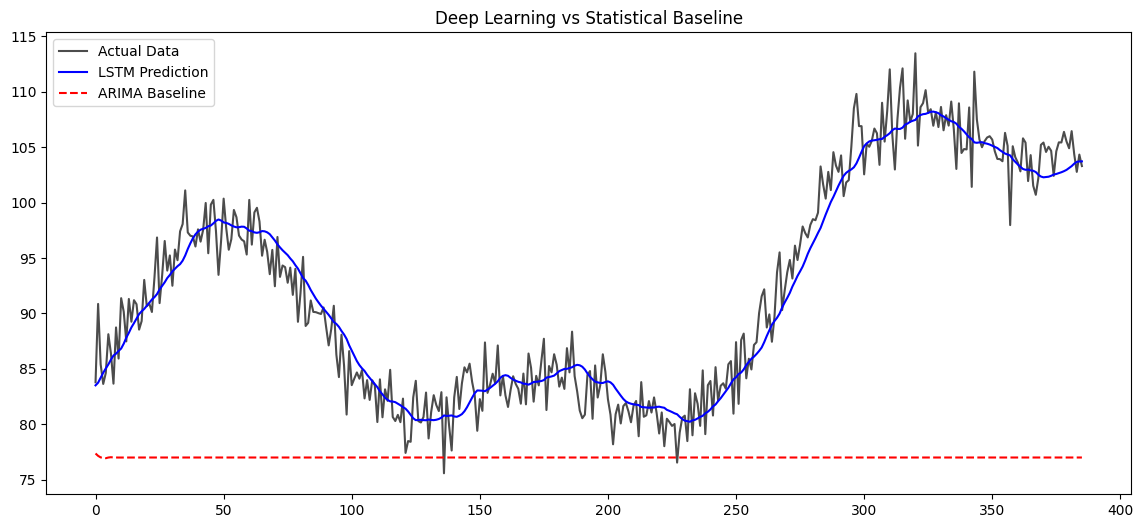

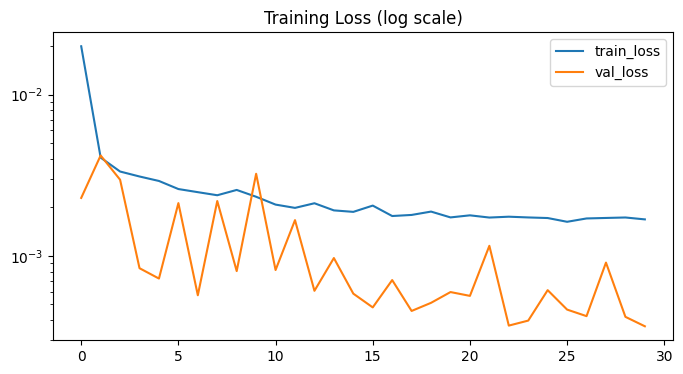

In [1]:
# multivariate time-series project
# Handles shapes, dtype conversions and plotting
# Includes LSTM training, ARIMA baseline, evaluation & plots

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import shap
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from statsmodels.tsa.arima.model import ARIMA
import time

# reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ==========================================
# TASK 1: Generate Complex Multivariate Data
# ==========================================
def generate_synthetic_data(n_steps=2000):
    time = np.arange(n_steps)
    trend = 0.05 * time
    seasonality = 10 * np.sin(0.02 * time) + 5 * np.sin(0.05 * time)
    noise = np.random.normal(0, 2, n_steps)
    y = trend + seasonality + noise
    feature_1 = np.roll(y, 10) + np.random.normal(0, 1, n_steps)
    feature_2 = -0.5 * trend + 10 * np.cos(0.02 * time) + np.random.normal(0, 2, n_steps)
    df = pd.DataFrame({
        'Feature_1': feature_1,
        'Feature_2': feature_2,
        'Target': y
    })
    return df.iloc[10:].reset_index(drop=True)

print("Generating Data...")
df = generate_synthetic_data()

plt.figure(figsize=(12, 5))
plt.plot(df['Target'], label='Target (Energy Load)')
plt.plot(df['Feature_1'], label='Feature 1', alpha=0.6)
plt.title("Synthetic Multivariate Time Series")
plt.legend()
plt.show()

# ==========================================
# PREPROCESSING: Windowing & Scaling
# ==========================================
def create_sequences(data, target, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

# Use the same features as in your original script (Target included as lag feature)
feature_cols = ['Feature_1', 'Feature_2', 'Target']
X_data = df[feature_cols].values
y_data = df[['Target']].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_data)
y_scaled = scaler_y.fit_transform(y_data)

TIME_STEPS = 60
X, y = create_sequences(X_scaled, y_scaled, TIME_STEPS)

# Ensure shapes are correct
print("Full sequence shapes:", X.shape, y.shape)  # (samples, time_steps, features), (samples, 1)

# Train/Test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training Shape: {X_train.shape}, Testing Shape: {X_test.shape}")

# Convert arrays to float32 (TensorFlow prefers float32)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# ==========================================
# TASK 2: Optimized LSTM Model
# ==========================================
def build_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(64, return_sequences=True, activation='tanh'),
        Dropout(0.2),
        LSTM(32, return_sequences=False, activation='tanh'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_model((X_train.shape[1], X_train.shape[2]))
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

print("\nTraining LSTM Model...")
history = model.fit(
    X_train, y_train,
    epochs=30,               # you can increase epochs if you have time
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Predictions
lstm_preds_scaled = model.predict(X_test)
lstm_preds = scaler_y.inverse_transform(lstm_preds_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

# ==========================================
# TASK 3: Explainability (SHAP)
# ==========================================
print("\nGenerating SHAP Values (GradientExplainer preferred)...")

# Prepare background and test tensors
bg_size = min(100, X_train.shape[0])
rng_idxs = np.random.choice(X_train.shape[0], bg_size, replace=False)
background_sample = X_train[rng_idxs]
test_sample = X_test[:10]

# convert to tf tensors of float32
bg_tf = tf.convert_to_tensor(background_sample, dtype=tf.float32)
test_tf = tf.convert_to_tensor(test_sample, dtype=tf.float32)

shap_values = None
used_explainer = None
start_time = time.time()

# Try GradientExplainer first (works with TF2 eager)
try:
    explainer = shap.GradientExplainer(model, bg_tf)
    shap_values = explainer.shap_values(test_tf)
    used_explainer = "GradientExplainer"
    print("Used GradientExplainer.")
except Exception as e:
    print("GradientExplainer failed with:", e)
    print("Falling back to KernelExplainer (slower).")
    # KernelExplainer expects 2D inputs -> flatten sequences
    def predict_flat(X_flat):
        n = X_flat.shape[0]
        X_reshaped = X_flat.reshape(n, X_train.shape[1], X_train.shape[2]).astype(np.float32)
        preds = model.predict(X_reshaped, verbose=0)
        return preds.flatten()
    # small background for kernel
    bg_flat = background_sample.reshape(background_sample.shape[0], -1)
    explainer = shap.KernelExplainer(predict_flat, bg_flat)
    test_flat = test_sample.reshape(test_sample.shape[0], -1)
    shap_values_flat = explainer.shap_values(test_flat, nsamples=200)  # nsamples controls speed/accuracy
    shap_values = np.array(shap_values_flat).reshape(test_flat.shape[0], X_train.shape[1], X_train.shape[2])
    used_explainer = "KernelExplainer"

end_time = time.time()
print(f"SHAP explainer used: {used_explainer}. Time taken: {end_time - start_time:.1f}s")

# If shap_values returns list (common), unwrap
if isinstance(shap_values, list):
    shap_values = shap_values[0]

shap_values = np.array(shap_values)  # shape should be (samples, time_steps, features)
print("shap_values.shape:", shap_values.shape)

# Average SHAP across time-steps to get per-feature importances
shap_avg_time = np.mean(shap_values, axis=1)          # (samples, features)
test_avg_time = np.mean(test_sample, axis=1)          # (samples, features)

# Feature names (match order used in X_data)
feature_names = ['Feature_1', 'Feature_2', 'Target_Lag']

# Plot summarized importance (bar)
plt.figure(figsize=(8, 4))
shap.summary_plot(shap_avg_time, test_avg_time, feature_names=feature_names, plot_type="bar", show=False)
plt.title("Feature importance (SHAP) - averaged over time window")
plt.tight_layout()
plt.show()

# Optional: heatmap showing contributions over time for first sample
sample_idx = 0
plt.figure(figsize=(10, 3))
plt.imshow(shap_values[sample_idx].T, aspect='auto')
plt.colorbar(label='SHAP value')
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Time step (window idx)')
plt.title(f"Time-resolved SHAP contributions (sample {sample_idx})")
plt.tight_layout()
plt.show()

# ==========================================
# TASK 4: Statistical Baseline (ARIMA)
# ==========================================
print("\nTraining Statistical Baseline (ARIMA)...")

# Prepare 1D series for ARIMA
# Note: We align the ARIMA test length to the LSTM comparison length below
train_arima = df['Target'].iloc[:split].values
test_arima = df['Target'].iloc[split:].values

# Fit ARIMA - (5,1,0) as an example (in practice use auto_arima)
arima_order = (5, 1, 0)
arima_model = ARIMA(train_arima, order=arima_order)
arima_fit = arima_model.fit()

forecast_res = arima_fit.get_forecast(steps=len(test_arima))
arima_preds_full = forecast_res.predicted_mean

# Align lengths for fair comparison
comparison_length = len(y_test_actual)
arima_preds = arima_preds_full[:comparison_length]
y_test_actual_comp = y_test_actual[:comparison_length]
lstm_preds_comp = lstm_preds[:comparison_length]

# ==========================================
# EVALUATION REPORT
# ==========================================
def calculate_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    # MAPE: protect against zero division
    mape = np.mean(np.abs((y_true - y_pred) / (np.where(y_true==0, 1e-8, y_true)))) * 100
    print(f"--- {model_name} Metrics ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    return rmse, mae, mape

print("\n=== Final Comparative Analysis ===")
rmse_lstm, mae_lstm, mape_lstm = calculate_metrics(y_test_actual_comp, lstm_preds_comp, "Deep Learning (LSTM)")
rmse_arima, mae_arima, mape_arima = calculate_metrics(y_test_actual_comp, arima_preds, "Baseline (ARIMA)")

# Visualization Comparison
plt.figure(figsize=(14, 6))
plt.plot(y_test_actual_comp, label='Actual Data', color='black', alpha=0.7)
plt.plot(lstm_preds_comp, label='LSTM Prediction', color='blue')
plt.plot(arima_preds, label='ARIMA Baseline', color='red', linestyle='--')
plt.title("Deep Learning vs Statistical Baseline")
plt.legend()
plt.show()

# Plot training loss/val_loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.title("Training Loss (log scale)")
plt.legend()
plt.show()
